In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import deque
import math

## 1.0 Overview

To evaluate the performance of the following stopping algorithms, we first need to define an underlying or “true” model that represents the raw feed rates, denoted as `|dw/dt|`. This model serves as the baseline from which we can run sufficient simulations to obtain an unbiased performance comparison.

Based on observations of the actual feed rate behavior, the model is structured as follows:

- The first half of the time series represents a high feed rate with natural fluctuations
- The second half represents a near-zero feed rate with residual noise, simulating the condition when beans have run out and there is essentially no weight change
- Between these two phases, two transitional midpoints are introduced to ensure a smooth decay, as an instantaneous drop from high to zero feed rate would be unrealistic

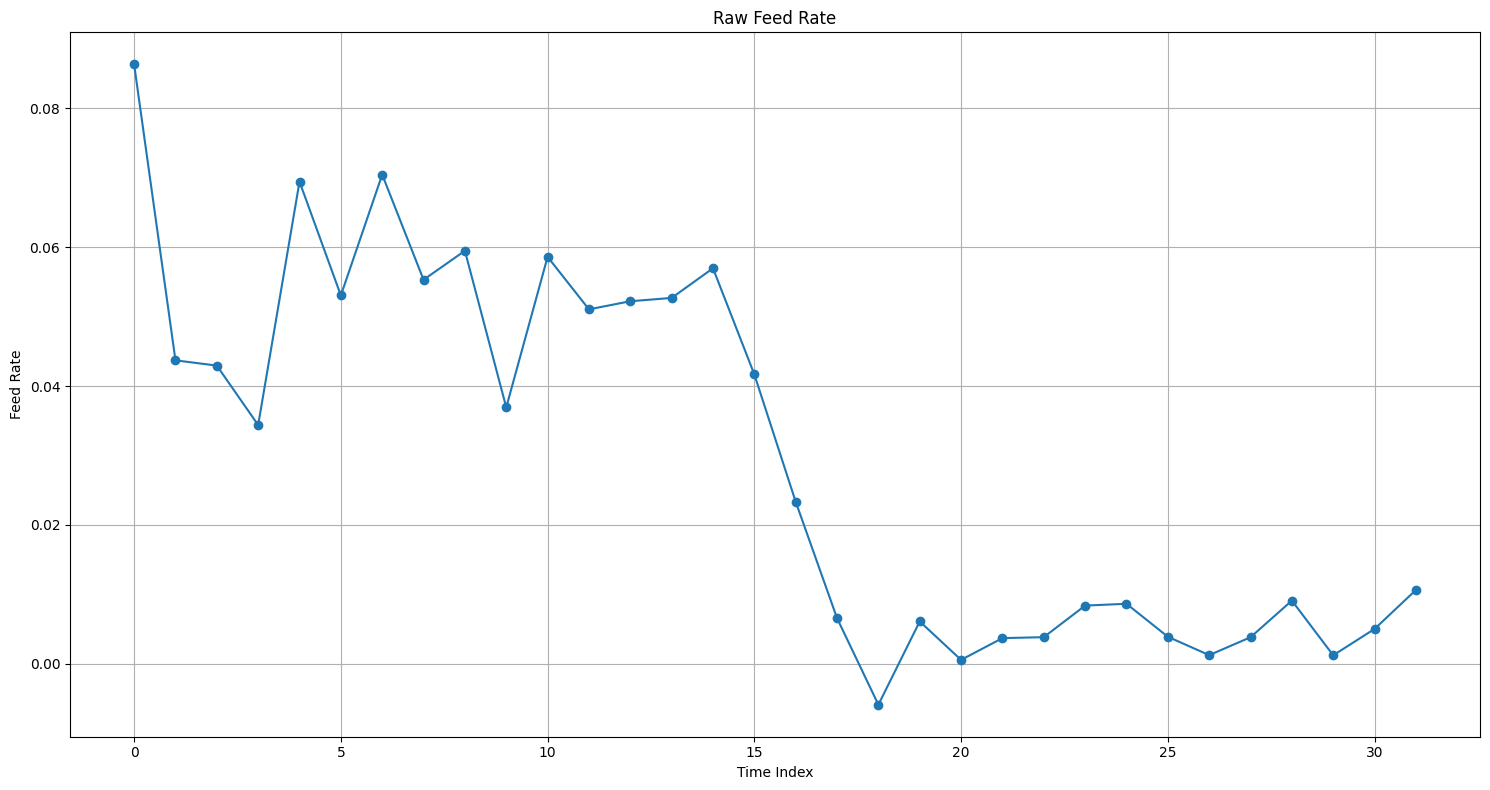

In [2]:
def generate_smoothed_rates(n1=15, n2=15, mean1=0.06, mean2=0.005, sigma1=0.015, sigma2=0.005, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    # Half-normal distributed noise (always positive)
    noise1 = rng.normal(loc=0, scale=sigma1, size=n1)
    noise2 = rng.normal(loc=0, scale=sigma2, size=n2)
    
    mid_points = np.linspace(mean1, mean2, num=4, endpoint=True)[1:3]

    # Add positive noise to the true means
    part1 = mean1 + noise1
    part2 = mean2 + noise2
    res = np.concatenate([part1, mid_points, part2])
    return res

# Example rates
rates = generate_smoothed_rates()
fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(rates, marker="o", linestyle="-", label="Raw signal")
ax1.set_xlabel("Time Index")
ax1.set_ylabel("Feed Rate")
ax1.set_title("Raw Feed Rate")
ax1.grid(True)
plt.tight_layout()
plt.show()

## 2.0 Algorithms
Four algorithms are examined below (2.2 - 2.4). Each algorithm is built upon the computation of a slow Exponential Moving Average (EMA) and a fast EMA. The key idea is that the fast EMA responds more quickly to new incoming data, while the slow EMA lags behind. When the feed rate drops toward zero, a noticeable gap emerges between the two EMAs. The objective of each algorithm is to detect this gap and determine when it becomes statistically significant.

### 2.1 Weight Change (Current)
This algorithm monitors the weight within a rolling window and checks whether the maximum and minimum values in that window are sufficiently close. When the range between them falls below a specified threshold, it indicates that the weight is no longer changing — suggesting that the beans have effectively run out.

In [3]:
def detect_weight_change(stream, alpha=0.3, windowSize=5):
    dt = 1
    smoothedRate = stream[0]
    weightChangeThreshold = 1.5
    weight_consec = 0
    window = deque([])
    changepoint = None
    weightStuck = False
    curr_weight = 0
    dt = 1.5
    ema = []
    
    for t, x in enumerate(stream):
        next_weight = curr_weight - smoothedRate * dt
        smoothedRate = alpha * x + (1 - alpha) * smoothedRate
        ema.append(smoothedRate)
        if len(window) == windowSize:
            window.popleft()
        window.append(next_weight)
        minWeight, maxWeight = min(window), max(window)
        curr_weight = next_weight

        if len(window) == windowSize:
            weightCond = maxWeight - minWeight < weightChangeThreshold
            if weightCond:
                weight_consec += 1
            else:
                weight_consec = 0
          
            if weight_consec == 2:
                weightStuck = True
            
                
            # if (weightCond and rateCond) or weightStuck or rateStuck:
            if weightCond and weightStuck:
                if not changepoint:
                    changepoint = t
                    
    return changepoint, np.array(ema)

### 2.2 Simple Dual EMA Gap
This algorithm simply monitors when fast EMA consistently drops below slow EMA.

In [4]:
def detect_ema_gap(stream, alpha_fast=0.4, alpha_slow=0.05,
                             k_sigma=2.5, dwell=5, delta_abs=0.01, min_obs=10):
    ema_fast = None
    ema_slow = None
    # EWMA of absolute residual around slow EMA to estimate noise
    sigma = 0.0
    alpha_sigma = 0.1
    obs = 0
    
    ema_fast_vals = []
    ema_slow_vals = []
    
    consec = 0
    changepoint = None
    for t, x in enumerate(stream):
        if ema_fast is None:
            ema_fast = ema_slow = float(x)
            sigma = 0.0
            ema_fast_vals.append(ema_fast)
            ema_slow_vals.append(ema_slow)
            continue

        obs += 1
        ema_fast = (1-alpha_fast)*ema_fast + alpha_fast*x
        ema_slow = (1-alpha_slow)*ema_slow + alpha_slow*x
        
        ema_fast_vals.append(ema_fast)
        ema_slow_vals.append(ema_slow)
        
        # noise estimate w.r.t. slow baseline
        res = abs(x - ema_slow)
        sigma = (1-alpha_sigma)*sigma + alpha_sigma*res

        gap = ema_slow - ema_fast   # positive when level is dropping
        # print(gap, sigma)
        # if gap > max(k_sigma*sigma, delta_abs):
        if gap > 0:
            consec += 1
            if consec >= dwell and obs >= min_obs and not changepoint:
                changepoint = t
        else:
            consec = 0
        
    return changepoint, np.array(ema_fast_vals), np.array(ema_slow_vals)

### 2.3 Dual EMA Gap Bollinger Band
This algorithm extends the concept of a Bollinger Band by using the gap’s own standard deviation to assess statistical significance — specifically, to determine whether the gap exceeds a defined confidence threshold, indicating a potential stop condition.

In [5]:
def detect_ema_gap_bb(stream,
                    alpha_fast=0.4, alpha_slow=0.05,
                    beta_var=0.3):
                           
    ema_f = None
    ema_s = None
    s2 = None     # EWMA variance of gap
    std_move = 1.3
    breach_cnt = 0
    consc = 2
    
    ema_fast_vals = []
    ema_slow_vals = []
    gap_var = []
    changepoint = None
    
    for t, x in enumerate(stream):
        if ema_f is None:
            ema_f = ema_s = float(x)
            ema_fast_vals.append(ema_f)
            ema_slow_vals.append(ema_s)
            s2 = 0.5
            gap_var.append(s2)
            continue

        # EMAs
        ema_f = (1 - alpha_fast) * ema_f + alpha_fast * x
        ema_s = (1 - alpha_slow) * ema_s + alpha_slow * x
        ema_f = min(ema_f, ema_s)
        d = ema_s - ema_f  # >0 when level drops
        
        ema_fast_vals.append(ema_f)
        ema_slow_vals.append(ema_s)
        # EWMA variance of (d - mu)
        s2 = (1 - beta_var) * s2 + beta_var * (d * d)
        gap_var.append(s2)
        if d > std_move * np.sqrt(s2):
            breach_cnt += 1
        else:
            breach_cnt = 0

        if breach_cnt == consc:
            if not changepoint:
                changepoint = t

    return changepoint, np.array(ema_fast_vals), np.array(ema_slow_vals), np.array(gap_var)

### 2.4 Dual EMA Gap CUMSUM
This algorithm uses the CUMSUM online algorithm to monitor the EMA gap.

In [6]:
def detect_ema_gap_cusum(stream,
                            alpha_fast=0.4, alpha_slow=0.05,   # EMAs
                            beta_mean = 0.05,
                            beta_var=0.05,      # EWMA stats of gap
                            k=0.5, h=6,                         # CUSUM params (few knobs)
                            min_obs=10,                          # wait for stable stats
                            eps=1e-8):
    ema_f = None
    ema_s = None
    mu = None     # EWMA mean of gap
    s2 = None     # EWMA variance of gap
    
    g = 0.0
    t_obs = 0
    
    ema_fast_vals = []
    ema_slow_vals = []
    g_vals = [g]

    changepoint = None
    
    for t, x in enumerate(stream):
        if ema_f is None:
            ema_f = ema_s = float(x)
            ema_fast_vals.append(ema_f)
            ema_slow_vals.append(ema_s)
            mu = 0.0
            s2 = 0.0
            continue

        # EMAs
        ema_f = (1 - alpha_fast) * ema_f + alpha_fast * x
        ema_s = (1 - alpha_slow) * ema_s + alpha_slow * x
        ema_fast_vals.append(ema_f)
        ema_slow_vals.append(ema_s)
        d = ema_s - ema_f  # >0 when level drops

        # EWMA mean/var of the gap (about 0 pre-change)
        mu = (1 - beta_mean) * mu + beta_mean * d
        # EWMA variance of (d - mu)
        dev = d - mu
        s2 = (1 - beta_var) * s2 + beta_var * (dev * dev)

        t_obs += 1
        if t_obs < min_obs:
            g_vals.append(g)
            continue  # wait until stats stabilize

        sigma = np.sqrt(s2) + eps
        z = dev / sigma  # standardized gap

        # One-sided CUSUM for positive shifts
        g = max(0.0, g + (z - k))
        g_vals.append(g)
        if g > h:
            if not changepoint:
                changepoint = t

    return changepoint, np.array(ema_fast_vals), np.array(ema_slow_vals), np.array(g_vals)

### 2.5 Dual EMA Gap Probabilistic CUMSUM
This algorithm uses the probabilistic version of the CUMSUM online algorithm to monitor the EMA gap.

In [7]:
def detect_ema_gap_probcusum(stream,
                            alpha_fast=0.4, alpha_slow=0.05,   # EMAs
                            beta_mean = 0.05,
                            beta_var=0.05,      # EWMA stats of gap
                            k=0,
                            confidence_interval = 0.05,
                            min_obs=10):
    ema_f = None
    ema_s = None
    gap_mu = None     # EWMA mean of gap
    gap_s2 = None     # EWMA variance of gap
    
    num_obs = 0
    z_obs = 0
    s = 0
    
    ema_fast_vals = []
    ema_slow_vals = []
    pvals = []
    changepoint = None
    
    for t, x in enumerate(stream):
        if ema_f is None:
            ema_f = ema_s = float(x)
            ema_fast_vals.append(ema_f)
            ema_slow_vals.append(ema_s)
            gap_mu = 0.0
            gap_s2 = 0.0
            continue

        # EMAs
        ema_f = (1 - alpha_fast) * ema_f + alpha_fast * x
        ema_s = (1 - alpha_slow) * ema_s + alpha_slow * x
        ema_f = min(ema_f, ema_s)
        
        ema_fast_vals.append(ema_f)
        ema_slow_vals.append(ema_s)
        d = ema_s - ema_f  # >0 when level drops

        # EWMA mean/var of the gap (about 0 pre-change)
        gap_mu = (1 - beta_mean) * gap_mu + beta_mean * d
        # EWMA variance of (d - mu)
        gap_dev = d - gap_mu
        gap_s2 = (1 - beta_var) * gap_s2 + beta_var * (gap_dev * gap_dev)

        num_obs += 1
        if num_obs < min_obs:
            pvals.append(0.5)
            continue  # wait until stats stabilize

        gap_sigma = np.sqrt(gap_s2)
        z = gap_dev / gap_sigma  # standardized gap
        z_obs += 1
        s += z

        
        standardized_s = s / np.sqrt(z_obs)
        # One-sided CUSUM for positive shifts
        pval = 1 - norm.cdf(standardized_s)
        # print(standardized_s, pval)
        pvals.append(pval)
        if pval < confidence_interval:
            if not changepoint:
                # print(t)
                changepoint = t
        # print(standardized_s)
        # print(pval)
    return changepoint, np.array(ema_fast_vals), np.array(ema_slow_vals), pvals

## 3.0 Experiments
All five algorithms are evaluated across four distinct datasets. Each dataset represents a unique feed rate pattern and variability level, simulating different physical configurations or user setups. For each dataset, 1,000 simulations are performed, and two key performance metrics are recorded: **accuracy rate** and **average lag**.

- **Accuracy** is defined as the proportion of simulations that successfully identify the change point at or after the first midpoint between the two feed-rate levels.  
- **Lag** is defined as the number of time indices between the detected change point and the true change point.

In [8]:
n_runs = 1000
CP_TRUE = 21
n1 = n2 = 20

param_sets = [
    {"mean1":0.1, "mean2":0.01, "sigma1":0.02, "sigma2":0.01},
    {"mean1":0.5, "mean2":0.01 , "sigma1":0.05, "sigma2":0.01},
    {"mean1":0.8,  "mean2":0.02,   "sigma1":0.2,  "sigma2":0.01},
    {"mean1":1.2,  "mean2":0.02,   "sigma1":0.5,   "sigma2":0.02},
]

# results = {}
# master_rng = np.random.default_rng(123)  # fixed seed for repeatability

master_seed = 123
master_rng = np.random.default_rng(master_seed)
streams = {}  # dict of arrays: key -> (n_runs, n1+n2)

for i, p in enumerate(param_sets, 1):
    key = f"set{i}"
    X = np.empty((n_runs, n1 + n2 + 2), dtype=float)
    for r in range(n_runs):
        X[r] = generate_smoothed_rates(n1=n1, n2=n2, rng=master_rng, **p)
    streams[key] = X

In [9]:
def metrics_from_cps(cps, cp_true=CP_TRUE):
    cps = np.array(cps, dtype=object)
    runs_total = len(cps)
    detected = [int(cp) for cp in cps if cp is not None]
    accurate = [cp for cp in detected if cp >= cp_true]
    lags = [cp - cp_true for cp in accurate]
    return {
        "runs_total": runs_total,
        "detected_count": len(detected),
        "accurate_count": len(accurate),
        "accuracy_rate": (len(accurate) / runs_total) if runs_total else np.nan,
        "avg_lag": (float(np.mean(lags)) if lags else np.nan),
    }

# Collect change points for each method
results = {
    "dual_ema": {},     
    "dual_ema_bb": {}, 
    "dual_ema_cusum": {}, 
    "dual_ema_probcumsum": {},
    "weight_diff": {}
}

for set_name, stream_list in streams.items():
    cps_weight_diff = []
    cps_dual_ema = []
    cps_dual_ema_bb = []
    cps_dual_ema_cumsum = []
    cps_dual_ema_probcumsum = []
    for stream in stream_list:
        cp_weight_diff, _ = detect_weight_change(stream)
        cp_dual_ema, _, _ = detect_ema_gap(stream, min_obs=15)
        cp_dual_ema_bb, _, _, _ = detect_ema_gap_bb(stream)
        cp_dual_ema_cumsum, _, _, _ = detect_ema_gap_cusum(stream, h=3, min_obs=15, k=0.5, eps=0)
        cp_dual_ema_probcumsum, _, _, _ = detect_ema_gap_probcusum(stream, k=0.5, min_obs=15)

        cps_weight_diff.append(cp_weight_diff)
        cps_dual_ema.append(cp_dual_ema)
        cps_dual_ema_bb.append(cp_dual_ema_bb)
        cps_dual_ema_cumsum.append(cp_dual_ema_cumsum)
        cps_dual_ema_probcumsum.append(cp_dual_ema_probcumsum)

    results["weight_diff"][set_name] = cps_weight_diff
    results["dual_ema"][set_name] = cps_dual_ema
    results["dual_ema_bb"][set_name] = cps_dual_ema_bb
    results["dual_ema_cusum"][set_name] = cps_dual_ema_cumsum
    results["dual_ema_probcumsum"][set_name] = cps_dual_ema_probcumsum

# Build a tidy DataFrame: index = set name, columns = (method, metric)
rows = sorted(streams.keys())  # e.g., ['set1','set2','set3']
cols = pd.MultiIndex.from_product(
    [["weight_diff", "dual_ema", "dual_ema_bb", "dual_ema_cusum", "dual_ema_probcumsum"], ["accuracy_rate", "avg_lag"]],
    names=["method", "metric"]
)

df = pd.DataFrame(index=rows, columns=cols, dtype=float)

for set_name in rows:
    m_weight_diff  = metrics_from_cps(results["weight_diff"][set_name], CP_TRUE)
    m_dual_ema   = metrics_from_cps(results["dual_ema"][set_name],   CP_TRUE)
    m_dual_ema_bb = metrics_from_cps(results["dual_ema_bb"][set_name],   CP_TRUE)
    m_dual_ema_cumsum  = metrics_from_cps(results["dual_ema_cusum"][set_name], CP_TRUE)
    m_dual_ema_probcumsum  = metrics_from_cps(results["dual_ema_probcumsum"][set_name], CP_TRUE)
    
    df.loc[set_name, ("weight_diff", "accuracy_rate")] = m_weight_diff["accuracy_rate"]
    df.loc[set_name, ("weight_diff", "avg_lag")]       = m_weight_diff["avg_lag"]
    df.loc[set_name, ("dual_ema", "accuracy_rate")]       = m_dual_ema["accuracy_rate"]
    df.loc[set_name, ("dual_ema", "avg_lag")]             = m_dual_ema["avg_lag"]
    df.loc[set_name, ("dual_ema_bb", "accuracy_rate")]  = m_dual_ema_bb["accuracy_rate"]
    df.loc[set_name, ("dual_ema_bb", "avg_lag")]        = m_dual_ema_bb["avg_lag"]
    df.loc[set_name, ("dual_ema_cusum", "accuracy_rate")] = m_dual_ema_cumsum["accuracy_rate"]
    df.loc[set_name, ("dual_ema_cusum", "avg_lag")]       = m_dual_ema_cumsum["avg_lag"]
    df.loc[set_name, ("dual_ema_probcumsum", "accuracy_rate")] = m_dual_ema_probcumsum["accuracy_rate"]
    df.loc[set_name, ("dual_ema_probcumsum", "avg_lag")]       = m_dual_ema_probcumsum["avg_lag"]
    

/var/folders/0q/bljmklsj56xbqmyw9zzkry2h0000gn/T/ipykernel_34244/162210466.py:52: RuntimeWarning: invalid value encountered in scalar divide
  z = gap_dev / gap_sigma  # standardized gap


## 4.0 Results
The results clearly show that the **`dual_ema_bb`** algorithm performs optimally, achieving consistently higher accuracy rates across all datasets while maintaining comparable or lower average lags. 

In addition, this algorithm benefits from requiring fewer hyperparameters, which reduces the risk of overfitting and improves its generalizability to a wider range of physical setups, variable wheel speeds, etc.

In [10]:
df

method   weight_diff              dual_ema             dual_ema_bb            \
metric accuracy_rate avg_lag accuracy_rate   avg_lag accuracy_rate   avg_lag   
set1             0.0     NaN         0.603  2.603648         0.893  1.996641   
set2             1.0   5.023         0.581  2.519793         0.993  0.033233   
set3             1.0   6.894         0.566  2.678445         0.842  0.485748   
set4             1.0   7.912         0.578  2.923875         0.687  0.818049   

method dual_ema_cusum           dual_ema_probcumsum            
metric  accuracy_rate   avg_lag       accuracy_rate   avg_lag  
set1            0.785  0.523567               0.459  0.490196  
set2            0.670  0.016418               0.376  0.148936  
set3            0.800  0.687500               0.486  0.629630  
set4            0.842  1.248219               0.526  1.207224

## 5.0 Examples
Some plotted example output of different algorithms

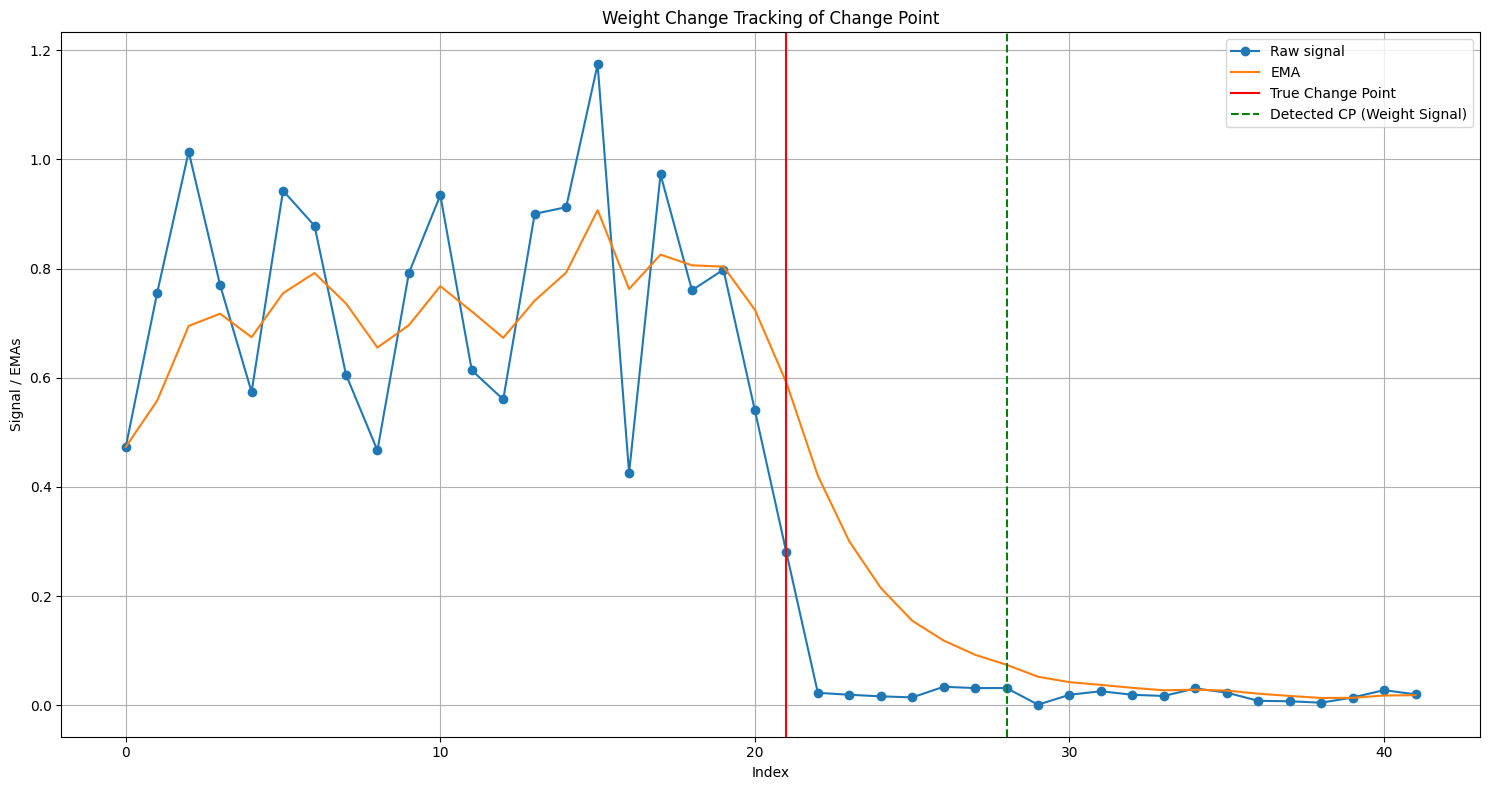

In [11]:
stream = streams['set3'][10]
cp_weight_diff, ema = detect_weight_change(stream)

fig, ax1 = plt.subplots(figsize=(15,8))

# --- Left y-axis (raw + EMAs) ---
ax1.plot(stream, marker="o", linestyle="-", label="Raw signal")
ax1.plot(ema, linestyle="-", label="EMA")
ax1.axvline(CP_TRUE, color="red", label="True Change Point")

if cp_weight_diff is not None:
    ax1.axvline(cp_weight_diff, color="green", linestyle="--", label="Detected CP (Weight Signal)")

ax1.set_xlabel("Index")
ax1.set_ylabel("Signal / EMAs")
ax1.set_title("Weight Change Tracking of Change Point")
ax1.grid(True)

lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc="upper right")

plt.tight_layout()
plt.show()


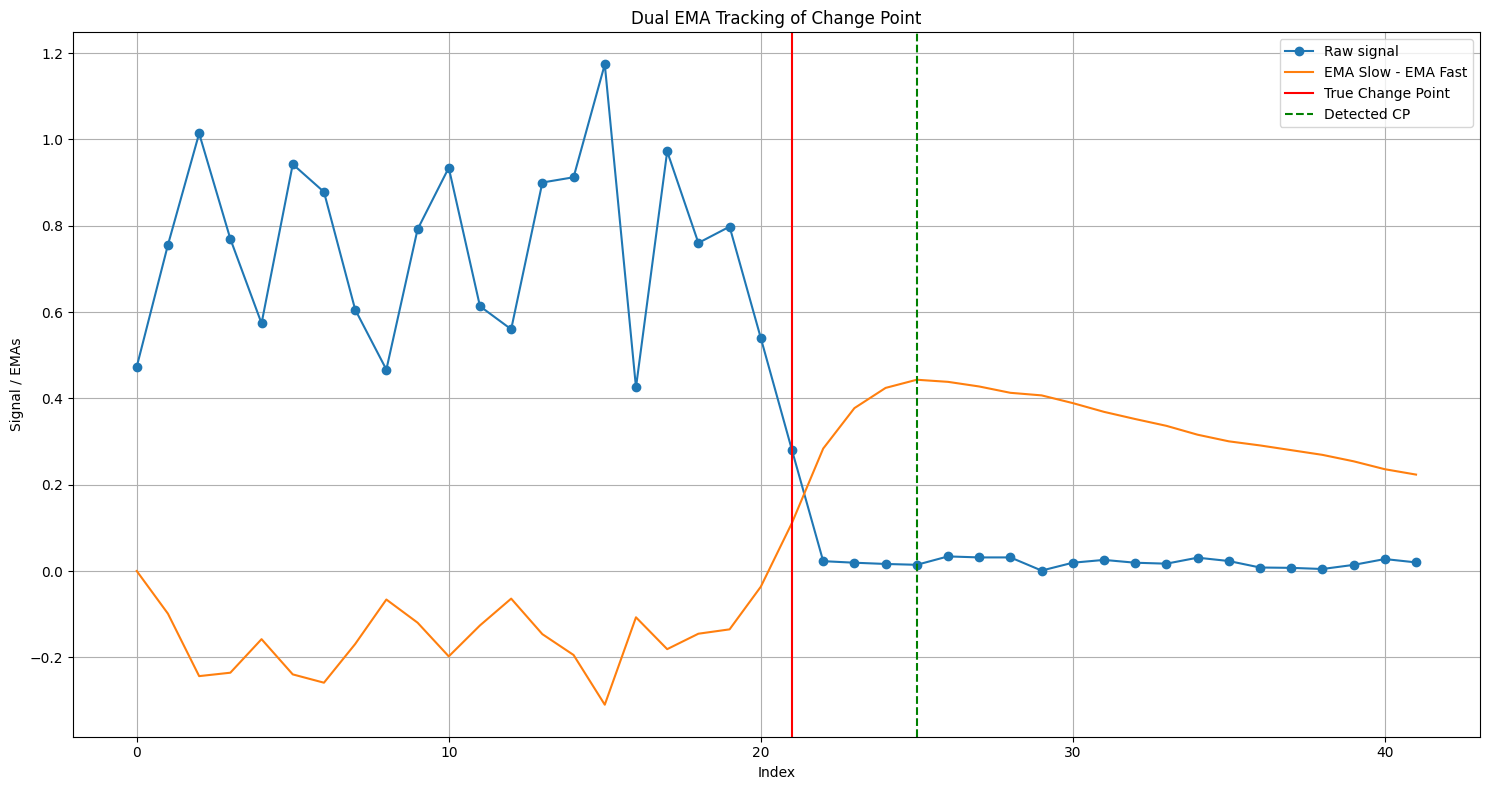

In [12]:
stream = streams['set3'][10]
cp_dual_ema, ema_fast_vals, ema_slow_vals = detect_ema_gap(stream, min_obs=CP_TRUE)

fig, ax1 = plt.subplots(figsize=(15,8))

ax1.plot(stream, marker="o", linestyle="-", label="Raw signal")
ax1.plot(ema_slow_vals - ema_fast_vals, linestyle="-", label="EMA Slow - EMA Fast")
ax1.axvline(CP_TRUE, color="red", label="True Change Point")

if cp_dual_ema is not None:
    ax1.axvline(cp_dual_ema, color="green", linestyle="--", label="Detected CP")

ax1.set_xlabel("Index")
ax1.set_ylabel("Signal / EMAs")
ax1.set_title("Dual EMA Tracking of Change Point")
ax1.grid(True)

lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc="upper right")

plt.tight_layout()
plt.show()

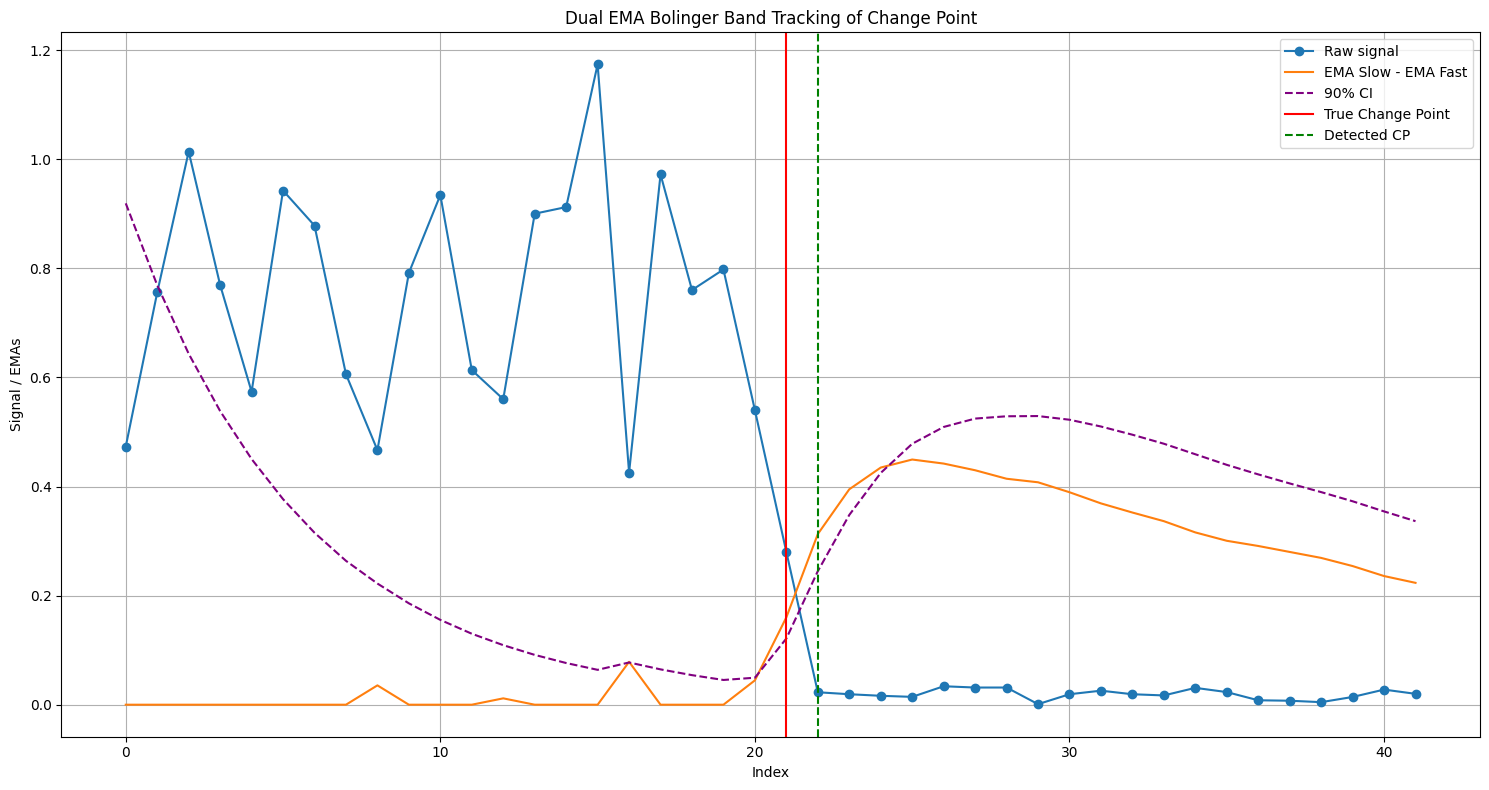

In [13]:
stream = streams['set3'][10]
cp_dual_ema_bb, ema_fast_vals, ema_slow_vals, gap_var = detect_ema_gap_bb(stream)

fig, ax1 = plt.subplots(figsize=(15,8))

ax1.plot(stream, marker="o", linestyle="-", label="Raw signal")
ax1.plot(ema_slow_vals - ema_fast_vals, linestyle="-", label="EMA Slow - EMA Fast")
ax1.plot(1.3*np.sqrt(gap_var), color="purple", linestyle="--", label="90% CI")
ax1.axvline(CP_TRUE, color="red", label="True Change Point")

if cp_dual_ema_bb is not None:
    ax1.axvline(cp_dual_ema_bb, color="green", linestyle="--", label="Detected CP")

ax1.set_xlabel("Index")
ax1.set_ylabel("Signal / EMAs")
ax1.set_title("Dual EMA Bolinger Band Tracking of Change Point")
ax1.grid(True)

# --- Combine legends from both axes ---
lines1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labels1, loc="upper right")

plt.tight_layout()
plt.show()

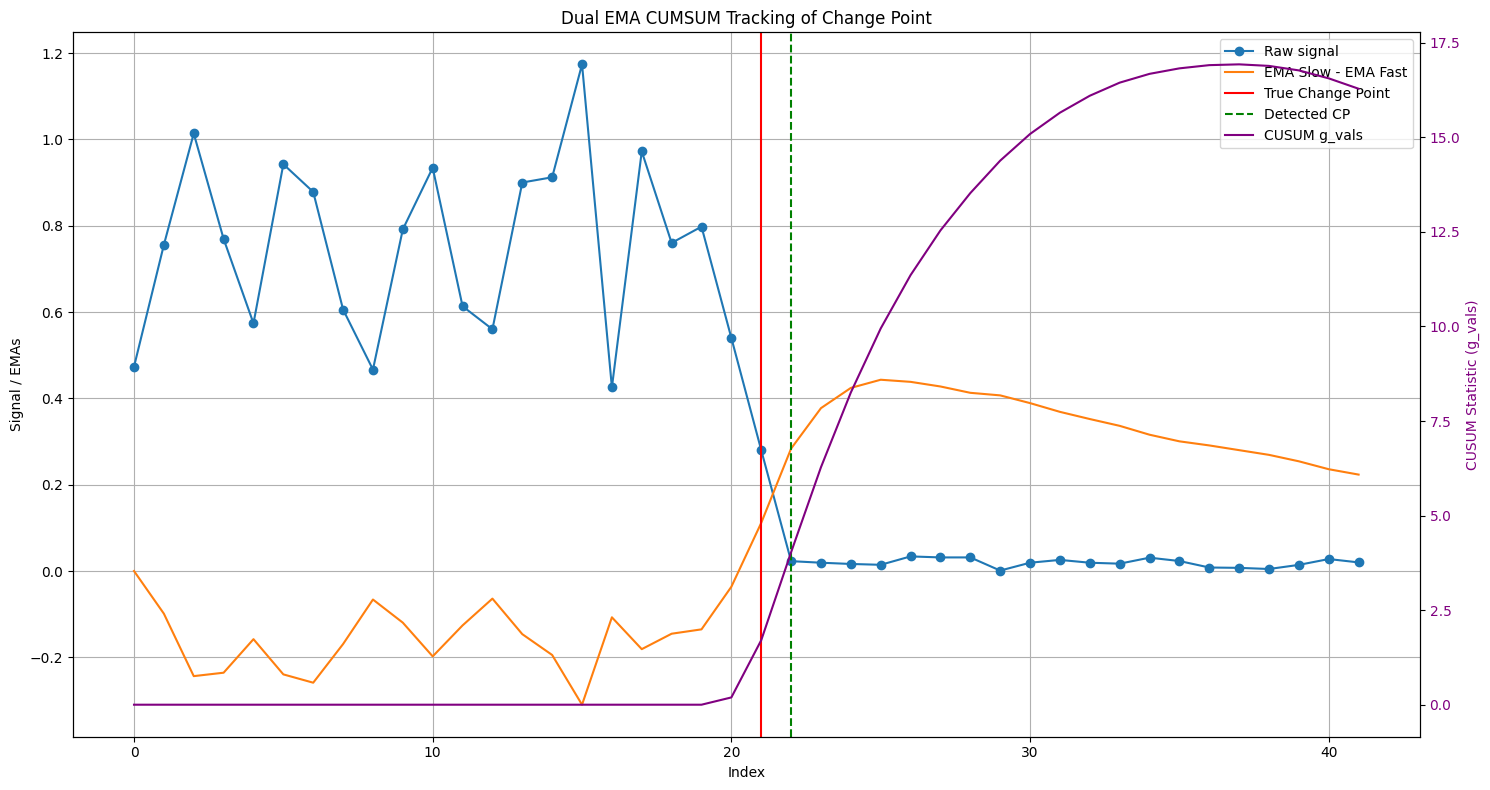

In [14]:
stream = streams['set3'][10]
cp_cusum, ema_fast_vals, ema_slow_vals, g_vals = detect_ema_gap_cusum(stream, h=3, min_obs=15)

fig, ax1 = plt.subplots(figsize=(15,8))

ax1.plot(stream, marker="o", linestyle="-", label="Raw signal")
ax1.plot(ema_slow_vals - ema_fast_vals, linestyle="-", label="EMA Slow - EMA Fast")
ax1.axvline(CP_TRUE, color="red", label="True Change Point")

if cp_cusum is not None:
    ax1.axvline(cp_cusum, color="green", linestyle="--", label="Detected CP")

ax1.set_xlabel("Index")
ax1.set_ylabel("Signal / EMAs")
ax1.set_title("Dual EMA CUMSUM Tracking of Change Point")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(g_vals, color="purple", linestyle="-", label="CUSUM g_vals")
ax2.set_ylabel("CUSUM Statistic (g_vals)", color="purple")
ax2.tick_params(axis="y", labelcolor="purple")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout()
plt.show()

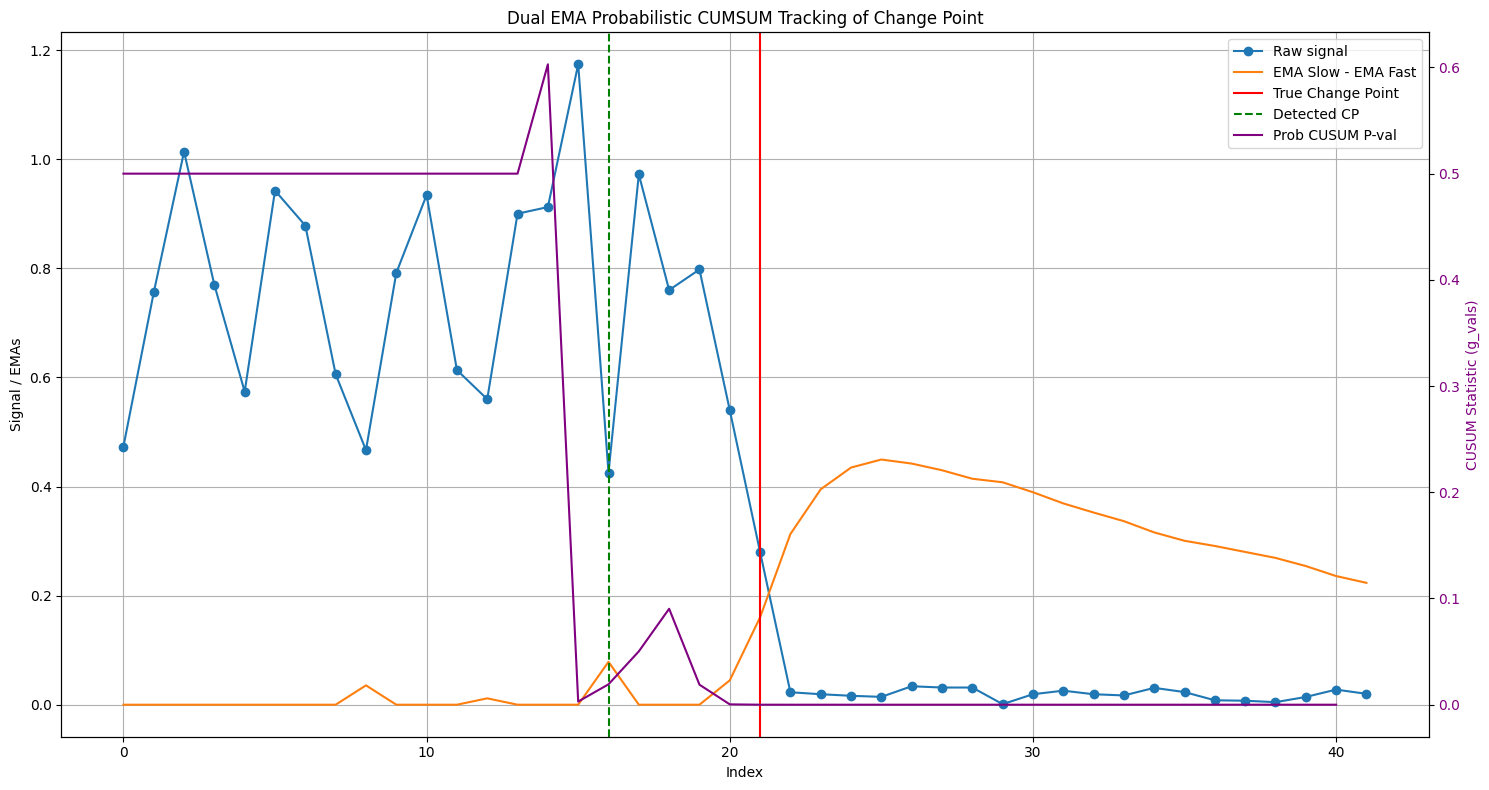

In [15]:
stream = streams['set3'][10]

cp, ema_fast_vals, ema_slow_vals, pvals = detect_ema_gap_probcusum(stream, k=0.5, min_obs=15)

fig, ax1 = plt.subplots(figsize=(15,8))

ax1.plot(stream, marker="o", linestyle="-", label="Raw signal")
ax1.plot(ema_slow_vals - ema_fast_vals, linestyle="-", label="EMA Slow - EMA Fast")
ax1.axvline(CP_TRUE, color="red", label="True Change Point")

if cp is not None:
    ax1.axvline(cp, color="green", linestyle="--", label="Detected CP")

ax1.set_xlabel("Index")
ax1.set_ylabel("Signal / EMAs")
ax1.set_title("Dual EMA Probabilistic CUMSUM Tracking of Change Point")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(pvals, color="purple", linestyle="-", label="Prob CUSUM P-val")
ax2.set_ylabel("CUSUM Statistic (g_vals)", color="purple")
ax2.tick_params(axis="y", labelcolor="purple")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout()
plt.show()